# Examining the relationship between DM actions and contrast using TensorFlow 2.x and hcipy.

## Description:
In this notebook we generate a static phasescreen, calculate the gradients of the contrast w.r.t. the DM actuators using TensorFlow, and use a gradient descent based optimizer to optimize for contrast. We look at the resulting dark hole electric field, examine the relationship between this field and the contrast, and study how it changes with respect to the DM action.

### Step 1: Installing hcipy on Colab.

In [ ]:
!pip uninstall hcipy
!rm -rf hcipy
!git clone https://github.com/ehpor/hcipy.git
!cd hcipy; git pull
!cd hcipy; python setup.py install

### Step 2: Importing necessary libraries and setting up optical system.

In [1]:
## Necessary imports
import numpy as np
from hcipy import *
import matplotlib.pyplot as plt
from astropy.io import fits
import os, glob
import time
from scipy.optimize import minimize

In [2]:
app_amp_file = "coronagraphs/Square_20_80_20_25_0_2_amp_resampled_256.fits"
app_phase_file = "coronagraphs/Square_20_80_20_25_0_2_phase_resampled_256.fits"

In [3]:
## Create aperture and pupil/focal grids
wavelength = 532e-9
N = 512
D = 10.5e-3
pupil_grid = make_pupil_grid(N, D)
science_focal_grid = make_focal_grid(8, 20, wavelength/D)
aperture = circular_aperture(D)

# Telescope parameters
Dtel=4
tel_pupil_grid = make_pupil_grid(N, Dtel)
tel_aperture = circular_aperture(Dtel)

## Create the deformable mirror
num_actuators = 25
actuator_spacing = D * 1.1 / num_actuators
xinetics_basis = make_xinetics_influence_functions(pupil_grid, num_actuators, actuator_spacing)
dm = DeformableMirror(xinetics_basis)
num_modes = len(dm.influence_functions)
dm.actuators = np.zeros(num_modes)

## Tweeter DM
dm2 = DeformableMirror(xinetics_basis)
dm2.actuators = np.zeros(num_modes)

# Atmosphere parameters
pixels_per_frame = 1
velocity = np.array([pixels_per_frame,0])
L0 = 40
r0 = 0.2
height = 0

# Make atmosphere
np.random.seed(19900305)
layers = []
layer = InfiniteAtmosphericLayer(tel_pupil_grid, Cn_squared_from_fried_parameter(r0, 500e-9), L0, velocity * tel_pupil_grid.delta[0], height, 2)
layer2 = ModalAdaptiveOpticsLayer(layer, dm.influence_functions, 1)
layers.append(layer2)
atmosphere = MultiLayerAtmosphere(layers, False)

## Create a demagnifier
mag = Magnifier(10.5e-3/4)

# Make initial phasescreen
wf_tel = Wavefront(tel_aperture(tel_pupil_grid), wavelength)
wf_tel.total_power = 100000
wf = mag.forward(wf_tel)

## Create propagator from pupil to focal plane
prop = FraunhoferPropagator(pupil_grid, science_focal_grid)

## Create a known phase diversity aberration
num_div_coeffs = 5
div_coeffs = np.zeros(num_div_coeffs)
div_zernike_basis = make_zernike_basis(num_div_coeffs, D, pupil_grid, 2)
div_coeffs[2] = 1
diversity_phase = np.dot(div_zernike_basis.transformation_matrix, div_coeffs)
diversity = Apodizer(np.exp(1j * diversity_phase))

## Create detector
science_camera = NoiselessDetector()
diversity_camera = NoiselessDetector()

## Create a spatial filter to simulate WFS
filt_aperture = circular_aperture(35)
spatial_filter = Apodizer(filt_aperture(science_focal_grid))

## Generate a diffraction limited image for metrics
diff_lim_img = prop(wf).power

## Get the unit lambda/D
l_D = wavelength / D
plot_grid = make_focal_grid(8, 20, 1)

## Create a noiseless camera image from the perfectly flat wavefront
dz_ind = np.where((diff_lim_img.grid.x >= (2 * l_D)) &\
                  (diff_lim_img.grid.x < (8 * l_D)) &\
                  (diff_lim_img.grid.y >= (-3 * l_D)) &\
                  (diff_lim_img.grid.y < (3 * l_D)))

# Setting up the vAPP calculation parameters.
contrast_level = 1e-5
contrast_map = science_focal_grid.ones()
contrast_map[dz_ind] = contrast_level
num_iterations = 80

# Generate the vAPP pattern.
vAPP = generate_app_keller(wf, prop, contrast_map, num_iterations, beta = 1)
app_amp = vAPP.amplitude / vAPP.amplitude.max()
app_phase = vAPP.phase

app = Apodizer(app_amp * np.exp(1j * app_phase))

## Create an NCP aberration
num_coeffs = 9
plaw_index = -1
np.random.seed(7)
#coeffs = ((np.random.rand(num_coeffs) - 0.5) * 2) * (np.arange(num_coeffs, dtype=float) + 1) ** plaw_index
#coeffs = np.zeros(coeffs.shape)
coeffs = np.array([0, 0, 0.5, 0, -0.4, 0, 0.3, 0.3, 0])
zernike_basis = make_zernike_basis(num_coeffs, D, pupil_grid, 2)
ncp_phase = np.dot(zernike_basis.transformation_matrix, coeffs)
ncp = Apodizer(np.exp(1j * ncp_phase))

# Create an estimate of the NCP aberration for the forward model
ncp_field_est = np.exp(1j * np.zeros(app_phase.shape))
initial_coeffs = np.zeros(coeffs.shape)

# Load the NCPA error term, i.e. the NCPA estimated by the phase diversity algorithm when no NCPA is present
#ncpa_error = np.load('ncpa_phase_error.npy')


In [4]:
meters_to_rads = (2 * np.pi) / wavelength
x = np.linspace(-1.1,1.1,25)
XX, YY = np.meshgrid(x,-1*x)
r_grid = np.sqrt(XX**2+YY**2)
mask = (r_grid<=1.2).ravel()

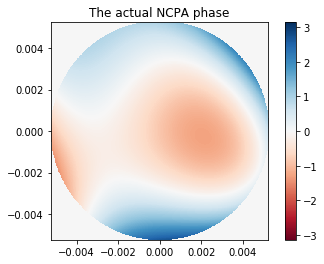

In [5]:
imshow_field(ncp_phase, grid=pupil_grid, vmin=-np.pi, vmax=np.pi, cmap='RdBu')
plt.title('The actual NCPA phase')
plt.colorbar()

### Step 3: Setting up the virtual model in TensorFlow.

In [6]:
import tensorflow as tf

In [7]:
@tf.function
def fraunhofer_tf(M1, M2, weights, wavelength, field):
    f = tf.reshape(field * tf.cast(weights, tf.complex128), (M1.shape[1], M2.shape[0]))
    result = -1j * tf.matmul(M1, tf.matmul(f, M2)) / wavelength
    return tf.reshape(result, [-1])

In [8]:
@tf.function
def contrast_metric(x, D, coron, ncp_field, dh_mask, cent_ind, E_in, wavelength, M1, M2, weights):
    '''Function to calculate the gradient of the contrast w.r.t. the DM actuators.
    x: Tensor variable with actuator values of the DM.
    D: Influence functions of the DM.
    coron: Electric field contribution from the coronagraph optics.
    ncp: Electric field contribution from non common path aberrations.
    dh_ind: Dark hole mask in the focal plane where contrast is evaluated.
    cent_ind: Central bright pixel indices in the focal plane used to evaluate contrast.
    E_in: Placeholder for the incident electric field being propagated through the optics.
    wavelength: Wavelength of the incident wavefront'''
  
    # Use the DM influence functions and actuator levels to determine the surface
    S = tf.linalg.matvec(D, x, name="dm_surface")
  
    # Calculate the electric field contribution from the DM
    dm_field = tf.exp(2j * (2 * np.pi / wavelength) * tf.cast(S, tf.complex128), name="dm_field")
    E_d = tf.math.multiply(E_in, dm_field, name="E_d")
  
    # Calculate the electric field contribution from the NCPA
    E_ncp = tf.math.multiply(E_d, ncp_field, name="E_ncp")
  
    # Calculate the electric field contribution from the coronagraph
    E_c = tf.math.multiply(E_ncp, coron, name="E_c")
  
    # Fraunhofer propagate the electric field to the focal plane
    E_f = fraunhofer_tf(M1, M2, weights, wavelength, E_c)
  
    # Calculate the focal plane intensity
    I_f = tf.square(tf.abs(E_f), name="I_f")
  
    # Extract the intensities from pixels at the dark hole and at the center
    dh_intens = tf.divide(tf.math.reduce_sum(tf.math.multiply(I_f, dh_mask)), tf.math.reduce_sum(dh_mask))
    cent_intens = I_f[cent_ind]
  
    # Calculate the average raw contrast in the dark hole
    contrast = tf.math.divide(dh_intens, cent_intens, name='contrast')
                      
    return contrast

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-9)

In [10]:
# Constants needed for the contrast calculation
uv_grid = science_focal_grid.scaled(2 * np.pi/ wavelength)
M1 = tf.convert_to_tensor(np.exp(-1j * np.outer(uv_grid.separated_coords[1], pupil_grid.separated_coords[1])))
M2 = tf.convert_to_tensor(np.exp(-1j * np.outer(uv_grid.separated_coords[0], pupil_grid.separated_coords[0])).T)
weights = tf.convert_to_tensor(pupil_grid.weights, dtype=tf.float64)
dm_mat = dm.influence_functions.transformation_matrix.toarray()
D = tf.constant(dm_mat, name="inf_mat", dtype=tf.float64)
app_field = app_amp * np.exp(1j * app_phase)
coron = tf.constant(app_field, dtype=tf.complex128, name="coron")
ncp_tensor = tf.convert_to_tensor(ncp_field_est, dtype=tf.complex128)
dh_mask = ((diff_lim_img.grid.x >= (2 * l_D)) * (diff_lim_img.grid.x <= (8 * l_D)) * (diff_lim_img.grid.y >= (-3 * l_D)) * (diff_lim_img.grid.y <= (3 * l_D))).astype(float)
dh_mask_tensor = tf.convert_to_tensor(dh_mask, tf.float64)
cent_ind = science_focal_grid.closest_to([0, 0])

In [11]:
inverse_tm = inverse_tikhonov(dm.influence_functions.transformation_matrix.toarray(), rcond=1e-4)

### Optimize using gradient descent

In [ ]:
# Reset atmosphere
np.random.seed(19900305)
atmosphere.evolve_until(None)
# Make sure lag is accounted for
for loop in np.arange(0.001, 0.1, 0.001):
    atmosphere.evolve_until(loop)

atmosphere.t += 1
wfatms_tel = atmosphere.forward(wf_tel)
wfatms = mag.forward(wfatms_tel)

dm.actuators = np.zeros(dm.actuators.shape)

dm2.actuators = np.zeros(dm2.actuators.shape)

flat_img = prop(app.forward(ncp.forward(dm2.forward(wfatms)))).power
flat_strehl = flat_img[np.argmax(diff_lim_img)] / diff_lim_img.max()
flat_contrast = flat_img[dz_ind].mean() / flat_img[np.argmax(diff_lim_img)]

In [ ]:
actuators = tf.Variable(dm2.actuators.copy(), dtype=tf.float64)

dm_wf = dm.forward(wfatms)
wf_to_optimize = dm_wf.copy()

E_in = tf.convert_to_tensor(wf_to_optimize.electric_field, dtype=tf.complex128)

for step in range(100):

    with tf.GradientTape() as tape:
        tape.watch(actuators)
        contrast_tf = contrast_metric(actuators, D, coron, ncp_tensor, dh_mask_tensor, cent_ind, E_in, wf.wavelength, M1, M2, weights)

    act_grads = tape.gradient(contrast_tf, [actuators])
    opt_step = optimizer.apply_gradients(zip(act_grads, [actuators]))

    dm2.actuators = actuators.numpy().copy()

grad_desc_contrast_opt_acts = dm2.actuators.copy()
grad_desc_contrast_opt_acts_masked = grad_desc_contrast_opt_acts * mask * meters_to_rads

grad_desc_img = prop(app.forward(ncp.forward(dm2.forward(wfatms)))).power
grad_desc_strehl = grad_desc_img[np.argmax(diff_lim_img)] / diff_lim_img.max()
grad_desc_contrast = grad_desc_img[dz_ind].mean() / grad_desc_img[np.argmax(diff_lim_img)]

plt.subplot(1, 2, 1)
imshow_field(np.log10(flat_img / flat_img.max()), vmin=-6, grid=plot_grid)
plt.title("PSF WF flattening\nStrehl={0:.4f}\nContrast= {1:.4E}".format(flat_strehl, flat_contrast))
plt.subplot(1, 2, 2)
imshow_field(np.log10(grad_desc_img / grad_desc_img.max()), vmin=-6, grid=plot_grid)
plt.title("PSF contrast opt\nStrehl={0:.4f}\nContrast= {1:.4E}".format(grad_desc_strehl, grad_desc_contrast))
plt.show()

In [ ]:
atms_img = prop(app.forward(wfatms)).power
atms_strehl = atms_img[np.argmax(diff_lim_img)] / diff_lim_img.max()
atms_contrast = atms_img[dz_ind].mean() / atms_img[np.argmax(diff_lim_img)]

imshow_field(np.log10(atms_img / atms_img.max()), vmin=-6, grid=plot_grid)
plt.title("No NCPA image\nStrehl={0:.4f}\nContrast= {1:.4E}".format(atms_strehl, atms_contrast))

In [ ]:
opt_img = prop(app.forward(dm2.forward(wfatms))).power
opt_strehl = opt_img[np.argmax(diff_lim_img)] / diff_lim_img.max()
opt_contrast = opt_img[dz_ind].mean() / opt_img[np.argmax(diff_lim_img)]

imshow_field(np.log10(opt_img / opt_img.max()), vmin=-6, grid=plot_grid)
plt.title("PSF optimized image\nStrehl={0:.4f}\nContrast= {1:.4E}".format(opt_strehl, opt_contrast))

In [12]:
def modal_decomposition(wf, basis):
    coeffs = np.dot(inverse_truncated(basis.transformation_matrix), wf.phase)
    return coeffs

def wf_reconstruction(coeffs, basis, pupil_grid, wavelength, aperture=1):
    wf_phase = np.dot(basis.transformation_matrix, coeffs)
    e_field = Field(np.exp(1j * wf_phase), pupil_grid)
    wfrecon = Wavefront(e_field * aperture(pupil_grid), wavelength)
    wfrecon.total_power=100000
    return wfrecon

def diversity_metric(x, basis, pupil_grid, wavelength, aperture, coronagraph, \
                     diversity, prop, img, div_img, correction, current_ncpa):
    # First calculate the estimated wavefront from the coefficients
    est_wf = wf_reconstruction(x, basis, pupil_grid, wavelength, aperture)
    
    # Add the offset from the DM as a correction term
    est_wf.electric_field *= correction
    
    # Add an offset for the current estimate of the NCPA
    #est_wf.electric_field *= current_ncpa
    
    # Propagate this estimated wf to the focal plane
    est_coron_wf = coronagraph.forward(est_wf)
    est_img = prop(est_coron_wf).power
    
    # Propagate this estimated wf to the focal plane with phase diversity
    est_div_wf = diversity.forward(est_coron_wf)
    est_div_img = prop(est_div_wf).power
    
    
    metric = 0.5 * np.sum((img - est_img) ** 2) + 0.5 * np.sum((div_img - est_div_img) ** 2)
    
    return metric

In [13]:
## Data to keep track of
flat_strehls = []
flat_contrasts = []
strehl_evol = []
contrast_evol = []
ncpa_phase_estimates = []
coeffs_list = []
sci_cam_readouts = []

## Dynamic atmosphere simulation parameters
duration = 700 # milliseconds
N = 200 # number of frames before readout

for timestep in np.arange(1, duration+1):
    print("Time is {} milliseconds. Phasescreen changes now.".format(timestep))
    
    ## Update the phasescreen
    atmosphere.t += 1
    wfatms_tel = atmosphere.forward(wf_tel)
    wfatms = mag.forward(wfatms_tel)
    
    flat_img = prop(app.forward(ncp.forward(wfatms))).power
    flat_strehl = flat_img[np.argmax(diff_lim_img)] / diff_lim_img.max()
    flat_contrast = flat_img[dz_ind].mean() / flat_img[np.argmax(diff_lim_img)]
    
    print("Pre-flattened WF strehl: {0:.4f} contrast: {1:.4E}".format(flat_strehl, flat_contrast))
    flat_strehls.append(flat_strehl)
    flat_contrasts.append(flat_contrast)
    
    ## Science optical path here
    dm_wf = dm2.forward(wfatms)
    ncp_wf = ncp.forward(dm_wf)
    app_wf = app.forward(ncp_wf)
    science_camera.integrate(prop(app_wf), dt=(1/N))
    
    ## Phase diversity optical path here
    div_wf = diversity.forward(app_wf)
    diversity_camera.integrate(prop(div_wf), dt=(1/N))
    
    ## Every N timesteps, readout the cameras and estimate NCP
    if timestep % N == 0:
        sci_img = science_camera.read_out()
        div_img = diversity_camera.read_out()
    
        sci_cam_readouts.append(sci_img)
        
        correction = np.exp(1j * np.zeros_like(wfatms.phase))
        
        estimator = minimize(diversity_metric, initial_coeffs, args=(zernike_basis, pupil_grid,\
                                                                        wavelength, aperture, app,\
                                                                        diversity, prop, sci_img,\
                                                                        div_img, correction, ncp_field_est))
        
        # Update the estimate of the ncp coefficients
        estimated_coeffs = estimator.x
        coeffs_list.append(estimated_coeffs.copy())

        # Reconstruct the NCPA phase aberration
        est_ncp_phase = np.dot(zernike_basis.transformation_matrix, estimated_coeffs)
        ncpa_phase_estimates.append(est_ncp_phase)

        dm_ncpa_surface = est_ncp_phase / (2 * wf.wavenumber)
        dm_ncpa_surface *= aperture(pupil_grid)
        dm_ncpa_acts = np.dot(inverse_tm, dm_ncpa_surface)
        
        dm2.actuators -= dm_ncpa_acts.copy()
        
    ## Display the strehl and contrast achieved by contrast optimization
    instant_img = prop(app.forward(ncp.forward(dm2.forward(wfatms)))).power
    instant_strehl = instant_img[np.argmax(diff_lim_img)] / diff_lim_img.max()
    instant_contrast = instant_img[dz_ind].mean() / instant_img[np.argmax(diff_lim_img)]
    print("Time = {0}ms: Instantaneous strehl: {1:.4f} instantaneous contrast: {2:.4E}\n".format(timestep, instant_strehl, instant_contrast))
    strehl_evol.append(instant_strehl)
    contrast_evol.append(instant_contrast)


Time is 1 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4030 contrast: 2.3233E-04
Time = 1ms: Instantaneous strehl: 0.4030 instantaneous contrast: 2.3233E-04

Time is 2 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4001 contrast: 2.8253E-04
Time = 2ms: Instantaneous strehl: 0.4001 instantaneous contrast: 2.8253E-04

Time is 3 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4003 contrast: 2.8219E-04
Time = 3ms: Instantaneous strehl: 0.4003 instantaneous contrast: 2.8219E-04

Time is 4 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4006 contrast: 2.8226E-04
Time = 4ms: Instantaneous strehl: 0.4006 instantaneous contrast: 2.8226E-04

Time is 5 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4011 contrast: 2.8268E-04
Time = 5ms: Instantaneous strehl: 0.4011 instantaneous contrast: 2.8268E-04

Time is 6 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4017 contrast: 2.8327E-04
Tim

Pre-flattened WF strehl: 0.4037 contrast: 2.7697E-04
Time = 47ms: Instantaneous strehl: 0.4037 instantaneous contrast: 2.7697E-04

Time is 48 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4042 contrast: 2.7448E-04
Time = 48ms: Instantaneous strehl: 0.4042 instantaneous contrast: 2.7448E-04

Time is 49 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4050 contrast: 2.7239E-04
Time = 49ms: Instantaneous strehl: 0.4050 instantaneous contrast: 2.7239E-04

Time is 50 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4061 contrast: 2.7039E-04
Time = 50ms: Instantaneous strehl: 0.4061 instantaneous contrast: 2.7039E-04

Time is 51 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4073 contrast: 2.6871E-04
Time = 51ms: Instantaneous strehl: 0.4073 instantaneous contrast: 2.6871E-04

Time is 52 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4086 contrast: 2.6759E-04
Time = 52ms: Instantaneous strehl: 0.4086 

Pre-flattened WF strehl: 0.4116 contrast: 2.8542E-04
Time = 93ms: Instantaneous strehl: 0.4116 instantaneous contrast: 2.8542E-04

Time is 94 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4125 contrast: 2.8576E-04
Time = 94ms: Instantaneous strehl: 0.4125 instantaneous contrast: 2.8576E-04

Time is 95 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4134 contrast: 2.8584E-04
Time = 95ms: Instantaneous strehl: 0.4134 instantaneous contrast: 2.8584E-04

Time is 96 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4144 contrast: 2.8564E-04
Time = 96ms: Instantaneous strehl: 0.4144 instantaneous contrast: 2.8564E-04

Time is 97 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4152 contrast: 2.8487E-04
Time = 97ms: Instantaneous strehl: 0.4152 instantaneous contrast: 2.8487E-04

Time is 98 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4160 contrast: 2.8357E-04
Time = 98ms: Instantaneous strehl: 0.4160 

Pre-flattened WF strehl: 0.4137 contrast: 3.0211E-04
Time = 138ms: Instantaneous strehl: 0.4137 instantaneous contrast: 3.0211E-04

Time is 139 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4144 contrast: 3.0252E-04
Time = 139ms: Instantaneous strehl: 0.4144 instantaneous contrast: 3.0252E-04

Time is 140 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4152 contrast: 3.0209E-04
Time = 140ms: Instantaneous strehl: 0.4152 instantaneous contrast: 3.0209E-04

Time is 141 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4159 contrast: 3.0093E-04
Time = 141ms: Instantaneous strehl: 0.4159 instantaneous contrast: 3.0093E-04

Time is 142 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4167 contrast: 2.9928E-04
Time = 142ms: Instantaneous strehl: 0.4167 instantaneous contrast: 2.9928E-04

Time is 143 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4174 contrast: 2.9707E-04
Time = 143ms: Instantaneous stre

Pre-flattened WF strehl: 0.4145 contrast: 3.0750E-04
Time = 183ms: Instantaneous strehl: 0.4145 instantaneous contrast: 3.0750E-04

Time is 184 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4151 contrast: 3.0171E-04
Time = 184ms: Instantaneous strehl: 0.4151 instantaneous contrast: 3.0171E-04

Time is 185 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4160 contrast: 2.9533E-04
Time = 185ms: Instantaneous strehl: 0.4160 instantaneous contrast: 2.9533E-04

Time is 186 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4171 contrast: 2.8904E-04
Time = 186ms: Instantaneous strehl: 0.4171 instantaneous contrast: 2.8904E-04

Time is 187 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4184 contrast: 2.8349E-04
Time = 187ms: Instantaneous strehl: 0.4184 instantaneous contrast: 2.8349E-04

Time is 188 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4197 contrast: 2.7930E-04
Time = 188ms: Instantaneous stre

Pre-flattened WF strehl: 0.4200 contrast: 2.6474E-04
Time = 228ms: Instantaneous strehl: 0.5953 instantaneous contrast: 1.0383E-04

Time is 229 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4207 contrast: 2.6195E-04
Time = 229ms: Instantaneous strehl: 0.5959 instantaneous contrast: 1.0407E-04

Time is 230 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4215 contrast: 2.5931E-04
Time = 230ms: Instantaneous strehl: 0.5967 instantaneous contrast: 1.0377E-04

Time is 231 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4223 contrast: 2.5721E-04
Time = 231ms: Instantaneous strehl: 0.5978 instantaneous contrast: 1.0313E-04

Time is 232 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4229 contrast: 2.5564E-04
Time = 232ms: Instantaneous strehl: 0.5988 instantaneous contrast: 1.0225E-04

Time is 233 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4233 contrast: 2.5450E-04
Time = 233ms: Instantaneous stre

Pre-flattened WF strehl: 0.4128 contrast: 3.3007E-04
Time = 273ms: Instantaneous strehl: 0.5893 instantaneous contrast: 1.0904E-04

Time is 274 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4134 contrast: 3.2817E-04
Time = 274ms: Instantaneous strehl: 0.5900 instantaneous contrast: 1.0652E-04

Time is 275 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4142 contrast: 3.2633E-04
Time = 275ms: Instantaneous strehl: 0.5909 instantaneous contrast: 1.0415E-04

Time is 276 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4151 contrast: 3.2465E-04
Time = 276ms: Instantaneous strehl: 0.5922 instantaneous contrast: 1.0207E-04

Time is 277 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4160 contrast: 3.2333E-04
Time = 277ms: Instantaneous strehl: 0.5935 instantaneous contrast: 1.0047E-04

Time is 278 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4169 contrast: 3.2222E-04
Time = 278ms: Instantaneous stre

Pre-flattened WF strehl: 0.4137 contrast: 3.5239E-04
Time = 318ms: Instantaneous strehl: 0.5933 instantaneous contrast: 1.0861E-04

Time is 319 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4143 contrast: 3.5097E-04
Time = 319ms: Instantaneous strehl: 0.5950 instantaneous contrast: 1.0575E-04

Time is 320 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4148 contrast: 3.4869E-04
Time = 320ms: Instantaneous strehl: 0.5968 instantaneous contrast: 1.0234E-04

Time is 321 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4152 contrast: 3.4623E-04
Time = 321ms: Instantaneous strehl: 0.5986 instantaneous contrast: 9.8621E-05

Time is 322 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4154 contrast: 3.4375E-04
Time = 322ms: Instantaneous strehl: 0.6002 instantaneous contrast: 9.4860E-05

Time is 323 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4154 contrast: 3.4129E-04
Time = 323ms: Instantaneous stre

Pre-flattened WF strehl: 0.4026 contrast: 3.6988E-04
Time = 363ms: Instantaneous strehl: 0.5879 instantaneous contrast: 1.0135E-04

Time is 364 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4032 contrast: 3.6397E-04
Time = 364ms: Instantaneous strehl: 0.5887 instantaneous contrast: 1.0037E-04

Time is 365 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4039 contrast: 3.5788E-04
Time = 365ms: Instantaneous strehl: 0.5897 instantaneous contrast: 9.9462E-05

Time is 366 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4046 contrast: 3.5218E-04
Time = 366ms: Instantaneous strehl: 0.5909 instantaneous contrast: 9.8759E-05

Time is 367 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4052 contrast: 3.4695E-04
Time = 367ms: Instantaneous strehl: 0.5922 instantaneous contrast: 9.8166E-05

Time is 368 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4058 contrast: 3.4218E-04
Time = 368ms: Instantaneous stre

Pre-flattened WF strehl: 0.3984 contrast: 3.3032E-04
Time = 408ms: Instantaneous strehl: 0.6237 instantaneous contrast: 1.1039E-04

Time is 409 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.3984 contrast: 3.2284E-04
Time = 409ms: Instantaneous strehl: 0.6245 instantaneous contrast: 1.0710E-04

Time is 410 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.3982 contrast: 3.1520E-04
Time = 410ms: Instantaneous strehl: 0.6253 instantaneous contrast: 1.0394E-04

Time is 411 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.3980 contrast: 3.0775E-04
Time = 411ms: Instantaneous strehl: 0.6262 instantaneous contrast: 1.0113E-04

Time is 412 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.3978 contrast: 3.0104E-04
Time = 412ms: Instantaneous strehl: 0.6269 instantaneous contrast: 9.8835E-05

Time is 413 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.3974 contrast: 2.9561E-04
Time = 413ms: Instantaneous stre

Pre-flattened WF strehl: 0.3980 contrast: 3.0258E-04
Time = 453ms: Instantaneous strehl: 0.6269 instantaneous contrast: 1.1905E-04

Time is 454 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.3979 contrast: 3.0246E-04
Time = 454ms: Instantaneous strehl: 0.6270 instantaneous contrast: 1.1944E-04

Time is 455 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.3979 contrast: 3.0223E-04
Time = 455ms: Instantaneous strehl: 0.6272 instantaneous contrast: 1.1999E-04

Time is 456 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.3981 contrast: 3.0241E-04
Time = 456ms: Instantaneous strehl: 0.6275 instantaneous contrast: 1.2084E-04

Time is 457 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.3984 contrast: 3.0322E-04
Time = 457ms: Instantaneous strehl: 0.6280 instantaneous contrast: 1.2199E-04

Time is 458 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.3989 contrast: 3.0437E-04
Time = 458ms: Instantaneous stre

Pre-flattened WF strehl: 0.4030 contrast: 3.4740E-04
Time = 498ms: Instantaneous strehl: 0.6291 instantaneous contrast: 1.3241E-04

Time is 499 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4032 contrast: 3.4666E-04
Time = 499ms: Instantaneous strehl: 0.6298 instantaneous contrast: 1.3228E-04

Time is 500 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4036 contrast: 3.4589E-04
Time = 500ms: Instantaneous strehl: 0.6307 instantaneous contrast: 1.3197E-04

Time is 501 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4042 contrast: 3.4496E-04
Time = 501ms: Instantaneous strehl: 0.6318 instantaneous contrast: 1.3141E-04

Time is 502 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4050 contrast: 3.4418E-04
Time = 502ms: Instantaneous strehl: 0.6329 instantaneous contrast: 1.3081E-04

Time is 503 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.4058 contrast: 3.4371E-04
Time = 503ms: Instantaneous stre

Pre-flattened WF strehl: 0.3941 contrast: 3.9924E-04
Time = 543ms: Instantaneous strehl: 0.6166 instantaneous contrast: 1.4097E-04

Time is 544 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.3940 contrast: 3.9637E-04
Time = 544ms: Instantaneous strehl: 0.6167 instantaneous contrast: 1.3886E-04

Time is 545 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.3943 contrast: 3.9350E-04
Time = 545ms: Instantaneous strehl: 0.6172 instantaneous contrast: 1.3677E-04

Time is 546 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.3950 contrast: 3.9026E-04
Time = 546ms: Instantaneous strehl: 0.6180 instantaneous contrast: 1.3479E-04

Time is 547 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.3960 contrast: 3.8665E-04
Time = 547ms: Instantaneous strehl: 0.6190 instantaneous contrast: 1.3297E-04

Time is 548 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.3973 contrast: 3.8293E-04
Time = 548ms: Instantaneous stre

Pre-flattened WF strehl: 0.3908 contrast: 2.9658E-04
Time = 588ms: Instantaneous strehl: 0.6112 instantaneous contrast: 9.3765E-05

Time is 589 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.3914 contrast: 2.9242E-04
Time = 589ms: Instantaneous strehl: 0.6121 instantaneous contrast: 9.3522E-05

Time is 590 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.3923 contrast: 2.8892E-04
Time = 590ms: Instantaneous strehl: 0.6133 instantaneous contrast: 9.3557E-05

Time is 591 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.3934 contrast: 2.8611E-04
Time = 591ms: Instantaneous strehl: 0.6148 instantaneous contrast: 9.3706E-05

Time is 592 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.3946 contrast: 2.8365E-04
Time = 592ms: Instantaneous strehl: 0.6165 instantaneous contrast: 9.3704E-05

Time is 593 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.3959 contrast: 2.8122E-04
Time = 593ms: Instantaneous stre

Pre-flattened WF strehl: 0.3945 contrast: 2.9689E-04
Time = 633ms: Instantaneous strehl: 0.6245 instantaneous contrast: 1.1721E-04

Time is 634 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.3946 contrast: 3.0021E-04
Time = 634ms: Instantaneous strehl: 0.6248 instantaneous contrast: 1.1815E-04

Time is 635 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.3949 contrast: 3.0317E-04
Time = 635ms: Instantaneous strehl: 0.6254 instantaneous contrast: 1.1887E-04

Time is 636 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.3952 contrast: 3.0553E-04
Time = 636ms: Instantaneous strehl: 0.6262 instantaneous contrast: 1.1922E-04

Time is 637 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.3955 contrast: 3.0699E-04
Time = 637ms: Instantaneous strehl: 0.6273 instantaneous contrast: 1.1918E-04

Time is 638 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.3958 contrast: 3.0757E-04
Time = 638ms: Instantaneous stre

Pre-flattened WF strehl: 0.3979 contrast: 3.4066E-04
Time = 678ms: Instantaneous strehl: 0.6291 instantaneous contrast: 1.3217E-04

Time is 679 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.3973 contrast: 3.3823E-04
Time = 679ms: Instantaneous strehl: 0.6284 instantaneous contrast: 1.3035E-04

Time is 680 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.3968 contrast: 3.3488E-04
Time = 680ms: Instantaneous strehl: 0.6279 instantaneous contrast: 1.2776E-04

Time is 681 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.3964 contrast: 3.3135E-04
Time = 681ms: Instantaneous strehl: 0.6276 instantaneous contrast: 1.2477E-04

Time is 682 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.3961 contrast: 3.2800E-04
Time = 682ms: Instantaneous strehl: 0.6276 instantaneous contrast: 1.2162E-04

Time is 683 milliseconds. Phasescreen changes now.
Pre-flattened WF strehl: 0.3959 contrast: 3.2565E-04
Time = 683ms: Instantaneous stre

In [ ]:
## Data to keep track of
flat_strehls = []
flat_contrasts = []
strehl_evol = []
contrast_evol = []
dm_actuator_evol = []
ncpa_phase_estimates = []
cumulative_ncp_field_estimates = []
coeffs_list = []
sci_cam_readouts = []

## Dynamic atmosphere simulation parameters
duration = 700 # milliseconds
N = 200 # number of frames before readout
opt_steps = 20 # number of optimization steps per phasescreen

optimizer_dyn = tf.keras.optimizers.Adam(learning_rate=1e-10)

for timestep in np.arange(1, duration+1):
    print("Time is {} milliseconds. Phasescreen changes and contrast optimizer runs now.".format(timestep))
    
    ## Update the phasescreen
    atmosphere.t += 1
    wfatms_tel = atmosphere.forward(wf_tel)
    wfatms = mag.forward(wfatms_tel)
    
    flat_img = prop(app.forward(ncp.forward(wfatms))).power
    flat_strehl = flat_img[np.argmax(diff_lim_img)] / diff_lim_img.max()
    flat_contrast = flat_img[dz_ind].mean() / flat_img[np.argmax(diff_lim_img)]
    
    print("Pre-flattened WF strehl: {0:.4f} contrast: {1:.4E}".format(flat_strehl, flat_contrast))
    flat_strehls.append(flat_strehl)
    flat_contrasts.append(flat_contrast)
    
    ## Get the pupil-plane electric field to optimize contrast for
    E_in = tf.convert_to_tensor(wfatms.electric_field, dtype=tf.complex128)
    
    ## Optimize contrast for this phasescreen
    for step in range(opt_steps):

        with tf.GradientTape() as tape:
            tape.watch(actuators)
            contrast_tf = contrast_metric(actuators, D, coron, ncp_tensor, dh_mask_tensor, cent_ind, E_in, wf.wavelength, M1, M2, weights)

        act_grads = tape.gradient(contrast_tf, [actuators])
        opt_step = optimizer_dyn.apply_gradients(zip(act_grads, [actuators]))

        dm2.actuators = actuators.numpy().copy()
    
    dm_actuator_evol.append(dm2.actuators.copy())
    
    ## Science optical path here
    dm_wf = dm2.forward(wfatms)
    ncp_wf = ncp.forward(dm_wf)
    app_wf = app.forward(ncp_wf)
    science_camera.integrate(prop(app_wf), dt=(1/N))
    
    ## Phase diversity optical path here
    div_wf = diversity.forward(app_wf)
    diversity_camera.integrate(prop(div_wf), dt=(1/N))
    
    ## Every N timesteps, readout the cameras and estimate NCP
    if timestep % N == 0:
        sci_img = science_camera.read_out()
        div_img = diversity_camera.read_out()
    
        sci_cam_readouts.append(sci_img)
        
        correction = np.exp(1j * np.zeros_like(wfatms.phase))
        
        estimator = minimize(diversity_metric, initial_coeffs, args=(zernike_basis, pupil_grid,\
                                                                        wavelength, aperture, app,\
                                                                        diversity, prop, sci_img,\
                                                                        div_img, correction, ncp_field_est))
        
        # Update the estimate of the ncp coefficients
        estimated_coeffs = estimator.x
        coeffs_list.append(estimated_coeffs.copy())

        # Reconstruct the NCPA phase aberration
        est_ncp_phase = np.dot(zernike_basis.transformation_matrix, estimated_coeffs)
        ncpa_phase_estimates.append(est_ncp_phase)

        # Now add this offset to the real DM
        ncp_field_est *= np.exp(1j * est_ncp_phase)
        cumulative_ncp_field_estimates.append(np.angle(ncp_field_est))
        ncp_tensor = tf.convert_to_tensor(ncp_field_est, dtype=tf.complex128)
        
    ## Display the strehl and contrast achieved by contrast optimization
    instant_img = prop(app.forward(ncp.forward(dm2.forward(wfatms)))).power
    instant_strehl = instant_img[np.argmax(diff_lim_img)] / diff_lim_img.max()
    instant_contrast = instant_img[dz_ind].mean() / instant_img[np.argmax(diff_lim_img)]
    print("Time = {0}ms: Instantaneous strehl: {1:.4f} instantaneous contrast: {2:.4E}\n".format(timestep, instant_strehl, instant_contrast))
    strehl_evol.append(instant_strehl)
    contrast_evol.append(instant_contrast)

In [ ]:
## Data to keep track of
flat_strehls = []
flat_contrasts = []
strehl_evol = []
contrast_evol = []
avg_post_dm_phases = []
ncpa_phase_estimates = []
cumulative_ncp_field_estimates = []
coeffs_list = []
sci_cam_readouts = []

## Dynamic atmosphere simulation parameters
duration = 700 # milliseconds
N = 200 # number of frames before readout
opt_steps = 20 # number of optimization steps per phasescreen

# Terms for calculating the turbulence effects
cap = app.forward(wf).electric_field
post_dm_phases = []

optimizer_dyn = tf.keras.optimizers.Adam(learning_rate=1e-10)

for timestep in np.arange(1, duration+1):
    print("Time is {} milliseconds. Phasescreen changes and contrast optimizer runs now.".format(timestep))
    
    ## Update the phasescreen
    atmosphere.t += 1
    wfatms_tel = atmosphere.forward(wf_tel)
    wfatms = mag.forward(wfatms_tel)
    
    flat_img = prop(app.forward(ncp.forward(wfatms))).power
    flat_strehl = flat_img[np.argmax(diff_lim_img)] / diff_lim_img.max()
    flat_contrast = flat_img[dz_ind].mean() / flat_img[np.argmax(diff_lim_img)]
    
    print("Pre-flattened WF strehl: {0:.4f} contrast: {1:.4E}".format(flat_strehl, flat_contrast))
    flat_strehls.append(flat_strehl)
    flat_contrasts.append(flat_contrast)
    
    ## Propagate the phasescreen beyond the DM
    dm_wf = dm2.forward(wfatms)
    E_in = tf.convert_to_tensor(wfatms.electric_field, dtype=tf.complex128)
    
    for step in range(opt_steps):

        with tf.GradientTape() as tape:
            tape.watch(actuators)
            contrast_tf = contrast_metric(actuators, D, coron, ncp_tensor, dh_mask_tensor, cent_ind, E_in, wf.wavelength, M1, M2, weights)

        act_grads = tape.gradient(contrast_tf, [actuators])
        opt_step = optimizer_dyn.apply_gradients(zip(act_grads, [actuators]))

        dm2.actuators = actuators.numpy().copy()
    
    ## Science optical path here
    dm_wf = dm2.forward(wfatms)
    ncp_wf = ncp.forward(dm_wf)
    app_wf = app.forward(ncp_wf)
    science_camera.integrate(prop(app_wf), dt=(1/N))
    
    ## Phase diversity optical path here
    div_wf = diversity.forward(app_wf)
    diversity_camera.integrate(prop(div_wf), dt=(1/N))
    
    # Remove piston from recorded phase and save it in memory
    post_dm_phases.append(dm_wf.phase - np.angle(np.mean(dm_wf.electric_field)))
    
    ## Every N timesteps, readout the cameras and estimate NCP
    if timestep % N == 0:
        sci_img = science_camera.read_out()
        div_img = diversity_camera.read_out()
    
        sci_cam_readouts.append(sci_img)
    
        ## Calculate the average post-DM phase and remove this from the phases
        phi_avg = np.mean(post_dm_phases, axis=0)
        post_dm_phases -= phi_avg
        
        # Save this for diagnostics
        avg_post_dm_phases.append(phi_avg)
    
        ## PSF correction term
        correction = np.exp(1j * phi_avg)
    
        ## Calculate the new complex apertures
        cap_sci = cap * correction
        cap_div = cap_sci * np.exp(1j * diversity_phase)
    
        ## Halo term
        ## For science image
        cpup = cap_sci * post_dm_phases
        cpup_wf = list(map(lambda x: Wavefront(Field(x, pupil_grid) * aperture(pupil_grid), wf.wavelength), cpup))
        cpup_intens = list(map(lambda x: prop(x).power, cpup_wf))
        Phalo_sci = np.sum(cpup_intens, axis=0) * (1/N)
        ## For diversity phase image
        cpup = cap_div * post_dm_phases
        cpup_wf = list(map(lambda x: Wavefront(Field(x, pupil_grid) * aperture(pupil_grid), wf.wavelength), cpup))
        cpup_intens = list(map(lambda x: prop(x).power, cpup_wf))
        Phalo_div = np.sum(cpup_intens, axis=0) * (1/N)
    
        ## Speckle term
        sqwv = np.sum(np.square(post_dm_phases), axis=0)
        sqwv /= N
    
        post_dm_phases = []
    
        ## For science image
        prod1 = Wavefront(Field(cap_sci * sqwv, pupil_grid) * aperture(pupil_grid), wf.wavelength) 
        prod2 = Wavefront(Field(cap_sci, pupil_grid) * aperture(pupil_grid), wf.wavelength)
        spec_complex = prop(prod1).electric_field * prop(prod2).electric_field.conj()
        Pspec_sci = spec_complex.real * science_focal_grid.weights
        ## For diversity phase image
        prod1 = Wavefront(Field(cap_div * sqwv, pupil_grid) * aperture(pupil_grid), wf.wavelength) 
        prod2 = Wavefront(Field(cap_div, pupil_grid) * aperture(pupil_grid), wf.wavelength)
        spec_complex = prop(prod1).electric_field * prop(prod2).electric_field.conj()
        Pspec_div = spec_complex.real * science_focal_grid.weights
    
        ## Subtract the halo and speckle terms from the science and phase diversity images
        sci_img -= (Phalo_sci - Pspec_sci)
        div_img -= (Phalo_div - Pspec_div)
    
        estimator = minimize(diversity_metric, initial_coeffs, args=(zernike_basis, pupil_grid,\
                                                                        wavelength, aperture, app,\
                                                                        diversity, prop, sci_img,\
                                                                        div_img, correction, ncp_field_est))
        
        # Update the estimate of the ncp coefficients
        estimated_coeffs = estimator.x
        coeffs_list.append(estimated_coeffs)

        # Reconstruct the NCPA phase aberration
        est_ncp_phase = np.dot(zernike_basis.transformation_matrix, estimated_coeffs)
        ncpa_phase_estimates.append(est_ncp_phase)

        # Now add this offset to the real DM
        ncp_field_est *= np.exp(1j * est_ncp_phase)
        cumulative_ncp_field_estimates.append(np.angle(ncp_field_est))
        ncp_tensor = tf.convert_to_tensor(ncp_field_est, dtype=tf.complex128)
        
    ## Display the strehl and contrast achieved by contrast optimization
    instant_img = prop(app.forward(ncp.forward(dm2.forward(wfatms)))).power
    instant_strehl = instant_img[np.argmax(diff_lim_img)] / diff_lim_img.max()
    instant_contrast = instant_img[dz_ind].mean() / instant_img[np.argmax(diff_lim_img)]
    print("Time = {0}ms: Instantaneous strehl: {1:.4f} instantaneous contrast: {2:.4E}\n".format(timestep, instant_strehl, instant_contrast))
    strehl_evol.append(instant_strehl)
    contrast_evol.append(instant_contrast)

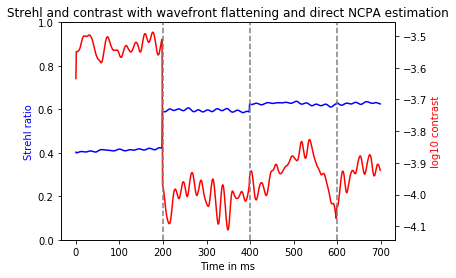

In [18]:
## Plot the strehl and contrast evolution with the atmosphere
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(strehl_evol, 'b')
ax2.plot(np.log10(contrast_evol), 'r')

ax1.set_xlabel('Time in ms')
ax1.set_ylabel('Strehl ratio', color='b')
ax1.set_ylim(0, 1)
ax2.set_ylabel('log10 contrast', color='r')

for plotline in np.arange(200, 800, 200):
    plt.axvline(plotline,  color='gray', linestyle='dashed')

plt.title("Strehl and contrast with wavefront flattening and direct NCPA estimation")
plt.show()

Text(0.5, 1.0, 'Estimated NCPA phase')

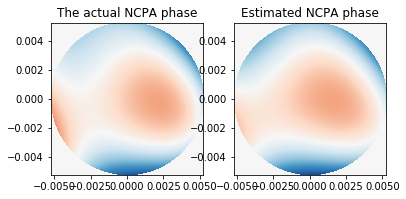

In [17]:
plt.subplot(1, 2, 1)
imshow_field(ncp_phase, grid=pupil_grid, vmin=-np.pi, vmax=np.pi, cmap='RdBu')
plt.title('The actual NCPA phase')
plt.subplot(1, 2, 2)
imshow_field(ncpa_phase_estimates[0], grid=pupil_grid, vmin=-np.pi, vmax=np.pi, cmap='RdBu')
plt.title('Estimated NCPA phase')

In [ ]:
plt.subplot(1, 3, 1)
imshow_field(ncp_phase, grid=pupil_grid, vmin=-np.pi, vmax=np.pi, cmap='RdBu')
plt.title('The actual NCPA phase')
plt.subplot(1, 3, 2)
imshow_field(cumulative_ncp_field_estimates[2], grid=pupil_grid, vmin=-np.pi, vmax=np.pi, cmap='RdBu')
plt.title('Estimated NCPA phase')
plt.subplot(1, 3, 3)
imshow_field(ncp_phase - cumulative_ncp_field_estimates[2], grid=pupil_grid, vmin=-np.pi, vmax=np.pi, cmap='RdBu')
plt.title('Residual phase')

In [ ]:
imshow_field(ncp_phase, grid=pupil_grid, vmin=-np.pi, vmax=np.pi, cmap='RdBu')
plt.title('The actual NCPA phase')
plt.colorbar()

In [ ]:
imshow_field(ncpa_phase_estimates[2], grid=pupil_grid, vmin=-np.pi, vmax=np.pi, cmap='RdBu')
plt.title('Estimated NCPA phase')
plt.colorbar()

In [ ]:
imshow_field(ncp_phase - cumulative_ncp_field_estimates[-1], grid=pupil_grid, vmin=-np.pi, vmax=np.pi, cmap='RdBu')
plt.title('Residual phase')
plt.colorbar()

In [ ]:
plt.plot(coeffs, 'r', label='Actual coeffs')
plt.plot(coeffs_list[0] + coeffs_list[1] + coeffs_list[2], 'b', label='Estimated coeffs')
plt.title("Actual NCPA Zernike coefficients vs estimated")
plt.legend(loc='best')

In [ ]:
plt.subplot(1, 3, 1)
imshow_field(ncpa_phase_estimates[0], grid=pupil_grid, vmin=-np.pi, vmax=np.pi, cmap='RdBu')
plt.subplot(1, 3, 2)
imshow_field(ncpa_phase_estimates[1], grid=pupil_grid, vmin=-np.pi, vmax=np.pi, cmap='RdBu')
plt.subplot(1, 3, 3)
imshow_field(ncpa_phase_estimates[2], grid=pupil_grid, vmin=-np.pi, vmax=np.pi, cmap='RdBu')

In [ ]:
imshow_field(avg_post_dm_phases[0], grid=pupil_grid, vmin=-np.pi/10, vmax=np.pi/10, cmap='RdBu')
plt.title('Average post-DM phase')
plt.colorbar()

In [ ]:
imshow_field(app_phase, grid=pupil_grid, vmin=-np.pi, vmax=np.pi, cmap='RdBu')
plt.title('APP phase addition')
plt.colorbar()

In [ ]:
imapp = prop(app.forward(wf)).power
imshow_field(np.log10(imapp / imapp.max()), vmin=-6, grid=plot_grid)
plt.colorbar()
plt.title('Instantaneous PSF\nContrast= {0:.4E}'.format(app_contrast))

In [ ]:
app_strehl = imapp[np.argmax(diff_lim_img)] / diff_lim_img.max()
app_contrast = imapp[dz_ind].mean() / imapp[np.argmax(diff_lim_img)]

In [ ]:
app_strehl

In [ ]:
app_contrast